# Statistik-Projekt HS25 – Notebook 03: Visualisierung
## Ziel
"Ein Bild sagt mehr als 1000 p-Werte."
In diesem Notebook visualisieren wir die Verteilungen unserer Zielvariable `Ankunftsverspätung`, um Muster zu erkennen und unsere Hypothesen visuell zu überprüfen.

Wir arbeiten mit einem **Zufalls-Sample** (Stichprobe) der Daten, da Plots mit 60+ Millionen Punkten extrem langsam sind und keine bessere Übersicht bieten (Overplotting).

## Geplante Visualisierungen
1.  **Globale Verteilung:** Wie sieht die Verspätung generell aus? (Histogramm)
2.  **Hypothese 1 (Zeit):** Boxplot der Verspätungen nach Tageszeit.
3.  **Hypothese 2 (Typ):** Boxplot der Verspätungen nach Zugtyp (Fernverkehr vs. S-Bahn).
4.  **Hypothese 3 (Tag):** Violinplot für Wochenende vs. Werktag.
5.  **ECDF:** Empirische Verteilungsfunktion für den Detail-Vergleich.

## Input
* Datei: `../data/processed/istdata_clean_extended.parquet`

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Konfiguration & Styling
INPUT_PATH = "../../data/processed/istdata_clean_extended.parquet"
FIG_PATH = "../reports/figures" # Ordner für Bilder
Path(FIG_PATH).mkdir(parents=True, exist_ok=True)

# Setzt den Style für alle Plots (optional)
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)

# 2. Daten laden & Sampeln
# Wir laden die Daten und ziehen sofort eine Stichprobe von 200.000 Zeilen.
# Das reicht statistisch völlig aus für Boxplots und ist schnell.
print("Lade Daten und ziehe Stichprobe...")

try:
    df_full = pl.read_parquet(INPUT_PATH)
    # Sample ziehen (mit seed für Reproduzierbarkeit)
    df_plot = df_full.sample(n=200000, seed=42).to_pandas()
    print(f"Stichprobe erstellt: {len(df_plot)} Zeilen (aus {len(df_full)} Gesamt).")
    
    # Speicherplatz freigeben (Original löschen)
    del df_full
    
except FileNotFoundError:
    print("❌ FEHLER: Datei nicht gefunden. Bitte Notebook 01 ausführen!")

Lade Daten und ziehe Stichprobe...
Stichprobe erstellt: 200000 Zeilen (aus 4201596 Gesamt).


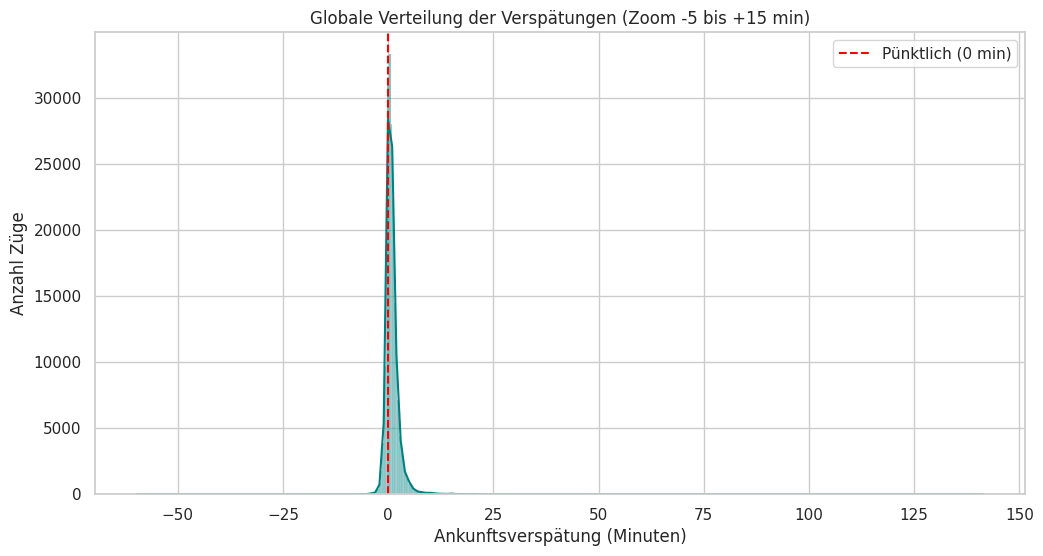

Erkenntnis: Die Verteilung ist stark rechtsschief (Long Tail). Die meisten Züge sind pünktlich, aber es gibt einen langen Schwanz an Verspätungen.


In [2]:
# Filter für den Plot: Wir zoomen auf den Bereich -5 bis +15 Minuten,
# da dort 95% der Daten liegen. Extreme Ausreißer würden das Histogramm unlesbar machen.
plt.figure(figsize=(12, 6))

sns.histplot(
    data=df_plot, 
    x="arr_delay_min", 
    bins=50, 
    binrange=(-5, 15), 
    kde=True, # Dichtekurve
    color="teal"
)

plt.axvline(0, color='red', linestyle='--', label="Pünktlich (0 min)")
plt.title("Globale Verteilung der Verspätungen (Zoom -5 bis +15 min)")
plt.xlabel("Ankunftsverspätung (Minuten)")
plt.ylabel("Anzahl Züge")
plt.legend()

# Speichern
plt.savefig(f"{FIG_PATH}/verteilung_global_hist.png", dpi=300)
plt.show()

print("Erkenntnis: Die Verteilung ist stark rechtsschief (Long Tail). Die meisten Züge sind pünktlich, aber es gibt einen langen Schwanz an Verspätungen.")

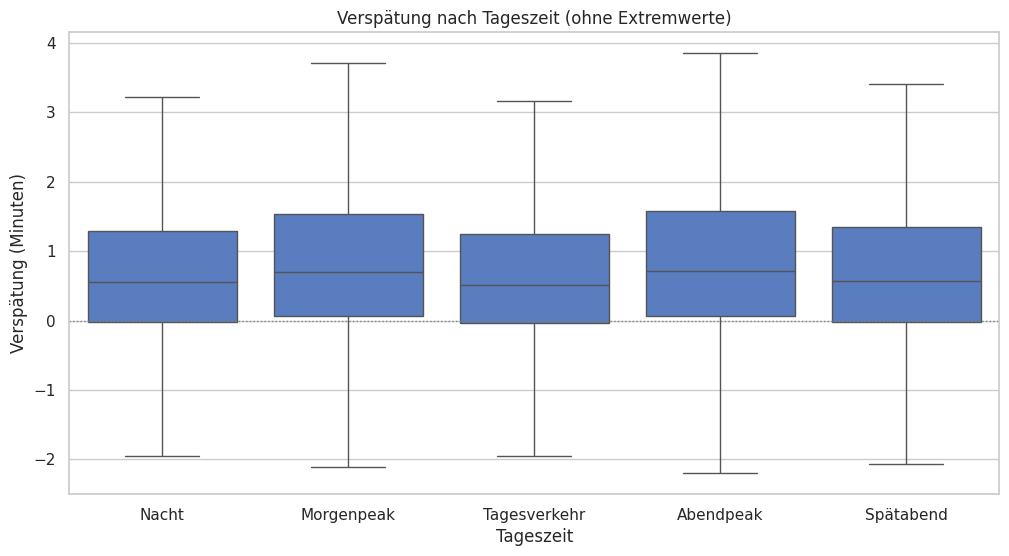

In [3]:
# Logische Reihenfolge für die X-Achse festlegen
time_order = ["Nacht", "Morgenpeak", "Tagesverkehr", "Abendpeak", "Spätabend"]

plt.figure(figsize=(12, 6))

# showfliers=False blendet die extremen Punkte aus, damit man die Boxen besser sieht
sns.boxplot(
    data=df_plot, 
    x="time_band", 
    y="arr_delay_min", 
    order=time_order,
    showfliers=False
)

plt.title("Verspätung nach Tageszeit (ohne Extremwerte)")
plt.ylabel("Verspätung (Minuten)")
plt.xlabel("Tageszeit")
plt.axhline(0, color='grey', linestyle=':', linewidth=1)

plt.savefig(f"{FIG_PATH}/hypothese_1_zeit_boxplot.png")
plt.show()

/tmp/ipykernel_9142/2359720406.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


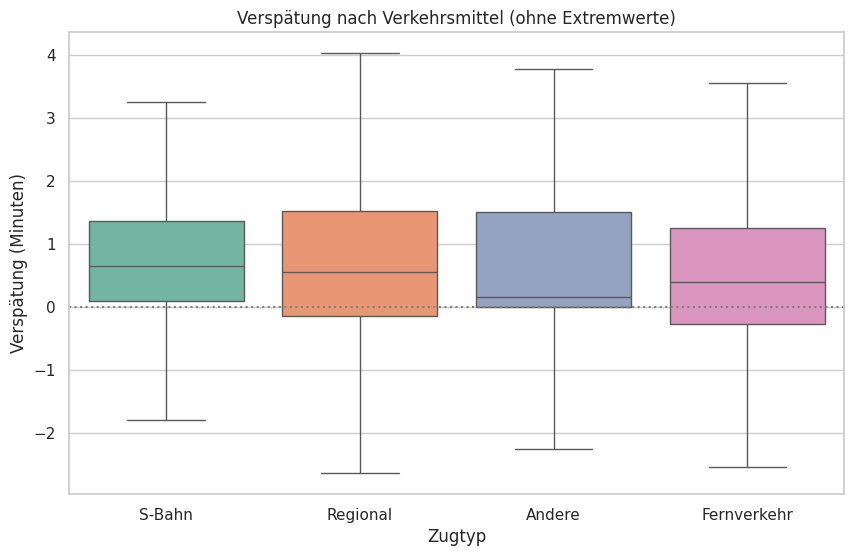

In [4]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_plot, 
    x="linientyp", 
    y="arr_delay_min", 
    showfliers=False,
    palette="Set2"
)

plt.title("Verspätung nach Verkehrsmittel (ohne Extremwerte)")
plt.ylabel("Verspätung (Minuten)")
plt.xlabel("Zugtyp")
plt.axhline(0, color='grey', linestyle=':')

plt.savefig(f"{FIG_PATH}/hypothese_2_typ_boxplot.png")
plt.show()

/tmp/ipykernel_9142/3737632901.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


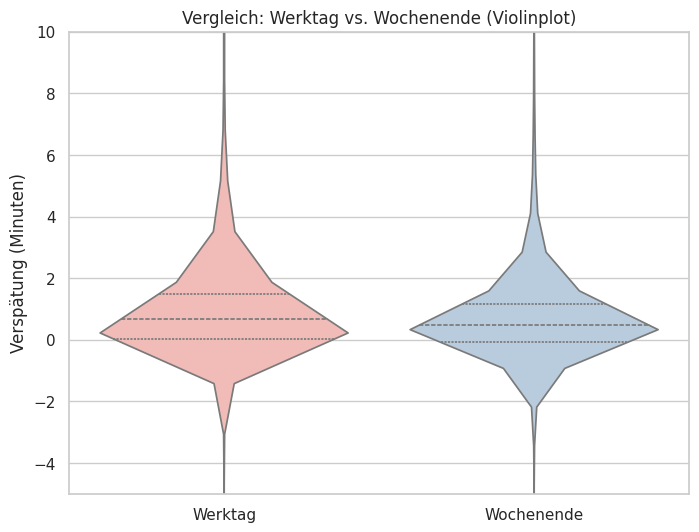

In [5]:
plt.figure(figsize=(8, 6))

# Umbenennen für schönere Achsenbeschriftung
df_plot["Tag_Typ"] = df_plot["is_weekend"].map({True: "Wochenende", False: "Werktag"})

sns.violinplot(
    data=df_plot, 
    x="Tag_Typ", 
    y="arr_delay_min", 
    inner="quart", # Zeigt Quartile im "Bauch" der Geige
    palette="Pastel1"
)

# Zoom auf relevanten Bereich, da Violins sonst sehr lang werden
plt.ylim(-5, 10)

plt.title("Vergleich: Werktag vs. Wochenende (Violinplot)")
plt.ylabel("Verspätung (Minuten)")
plt.xlabel("")

plt.savefig(f"{FIG_PATH}/hypothese_3_wochenende_violin.png")
plt.show()

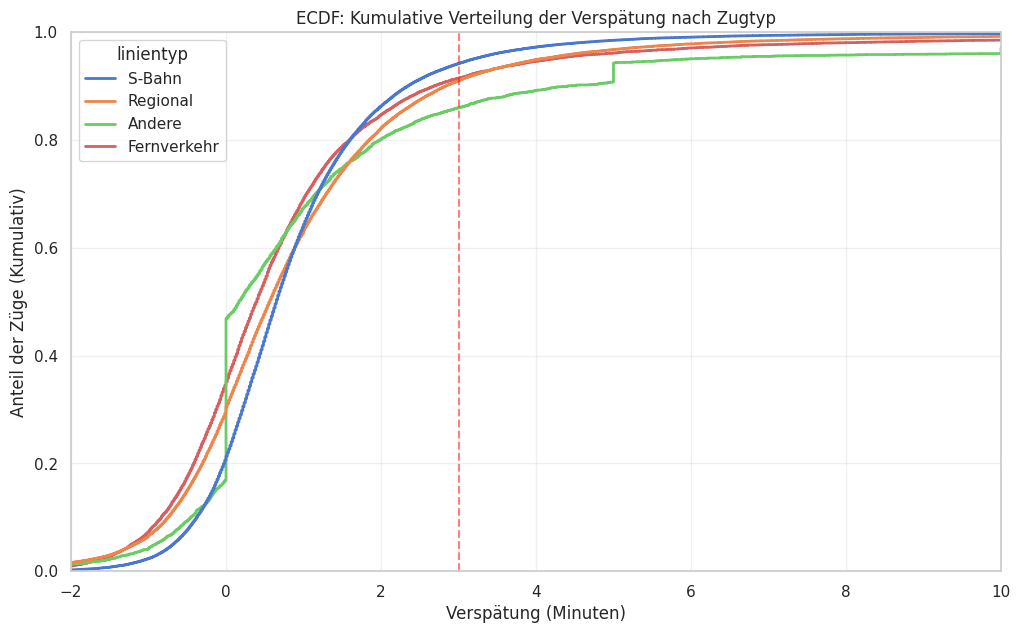

Lesehilfe: Schneidet eine Linie die 3-Minuten-Marke höher, ist dieser Zugtyp pünktlicher (mehr Züge unter der Grenze).


In [6]:
plt.figure(figsize=(12, 7))

# Wir vergleichen hier die Linientypen
sns.ecdfplot(
    data=df_plot, 
    x="arr_delay_min", 
    hue="linientyp",
    linewidth=2
)

# Hilfslinien für die 3-Minuten-Grenze (SBB Pünktlichkeit)
plt.axvline(3, color='red', linestyle='--', alpha=0.5, label="3 Min Grenze")
plt.xlim(-2, 10) # Zoom

plt.title("ECDF: Kumulative Verteilung der Verspätung nach Zugtyp")
plt.xlabel("Verspätung (Minuten)")
plt.ylabel("Anteil der Züge (Kumulativ)")
plt.grid(True, alpha=0.3)

plt.savefig(f"{FIG_PATH}/ecdf_linientyp.png")
plt.show()

print("Lesehilfe: Schneidet eine Linie die 3-Minuten-Marke höher, ist dieser Zugtyp pünktlicher (mehr Züge unter der Grenze).")